# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

17 marketing campaigns were organized to collect this data


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
!pip install category_encoders

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px

import re
import warnings
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score,classification_report, accuracy_score
import category_encoders as ce
from sklearn.impute import SimpleImputer
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.2 MB/s eta 0:00:00


In [101]:
bank_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
bank_df_smallsize = pd.read_csv('data/bank-additional.csv', sep = ';') # Use this dataframe to test large models.

In [102]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [103]:
# Remove duplicates which are 12 records
bank_df=bank_df.drop_duplicates()
bank_df_smallsize = bank_df_smallsize.drop_duplicates()
bank_df.shape

(41176, 21)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [104]:
bank_df = bank_df.rename(columns={
    'emp.var.rate': 'employment_variation_rate',
    'cons.price.idx': 'consumer_price_index',
    'cons.conf.idx': 'consumer_confidence_index',
    'nr.employed': 'number_of_employees',
    'euribor3m': 'euribor_3_month_rate',
    'pdays': 'days_since_last_contact',
    'poutcome': 'previous_outcome'
})
bank_df_smallsize = bank_df_smallsize.rename(columns={
    'emp.var.rate': 'employment_variation_rate',
    'cons.price.idx': 'consumer_price_index',
    'cons.conf.idx': 'consumer_confidence_index',
    'nr.employed': 'number_of_employees',
    'euribor3m': 'euribor_3_month_rate',
    'pdays': 'days_since_last_contact',
    'poutcome': 'previous_outcome'
})
bank_df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,days_since_last_contact,previous,previous_outcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_month_rate,number_of_employees,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [105]:
bank_df.describe(include='object')
bank_df.shape


(41176, 21)

In [106]:
categorical_columns = ['default','contact', 'month', 'day_of_week','previous_outcome','job','marital','education','housing','loan','y']

for col in categorical_columns:
    print(col)
    print(bank_df[col].value_counts())


bank_df.dropna()

default
default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64
contact
contact
cellular     26135
telephone    15041
Name: count, dtype: int64
month
month
may    13767
jul     7169
aug     6176
jun     5318
nov     4100
apr     2631
oct      717
sep      570
mar      546
dec      182
Name: count, dtype: int64
day_of_week
day_of_week
thu    8618
mon    8512
wed    8134
tue    8086
fri    7826
Name: count, dtype: int64
previous_outcome
previous_outcome
nonexistent    35551
failure         4252
success         1373
Name: count, dtype: int64
job
job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
marital
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64
ed

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,days_since_last_contact,previous,previous_outcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_month_rate,number_of_employees,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


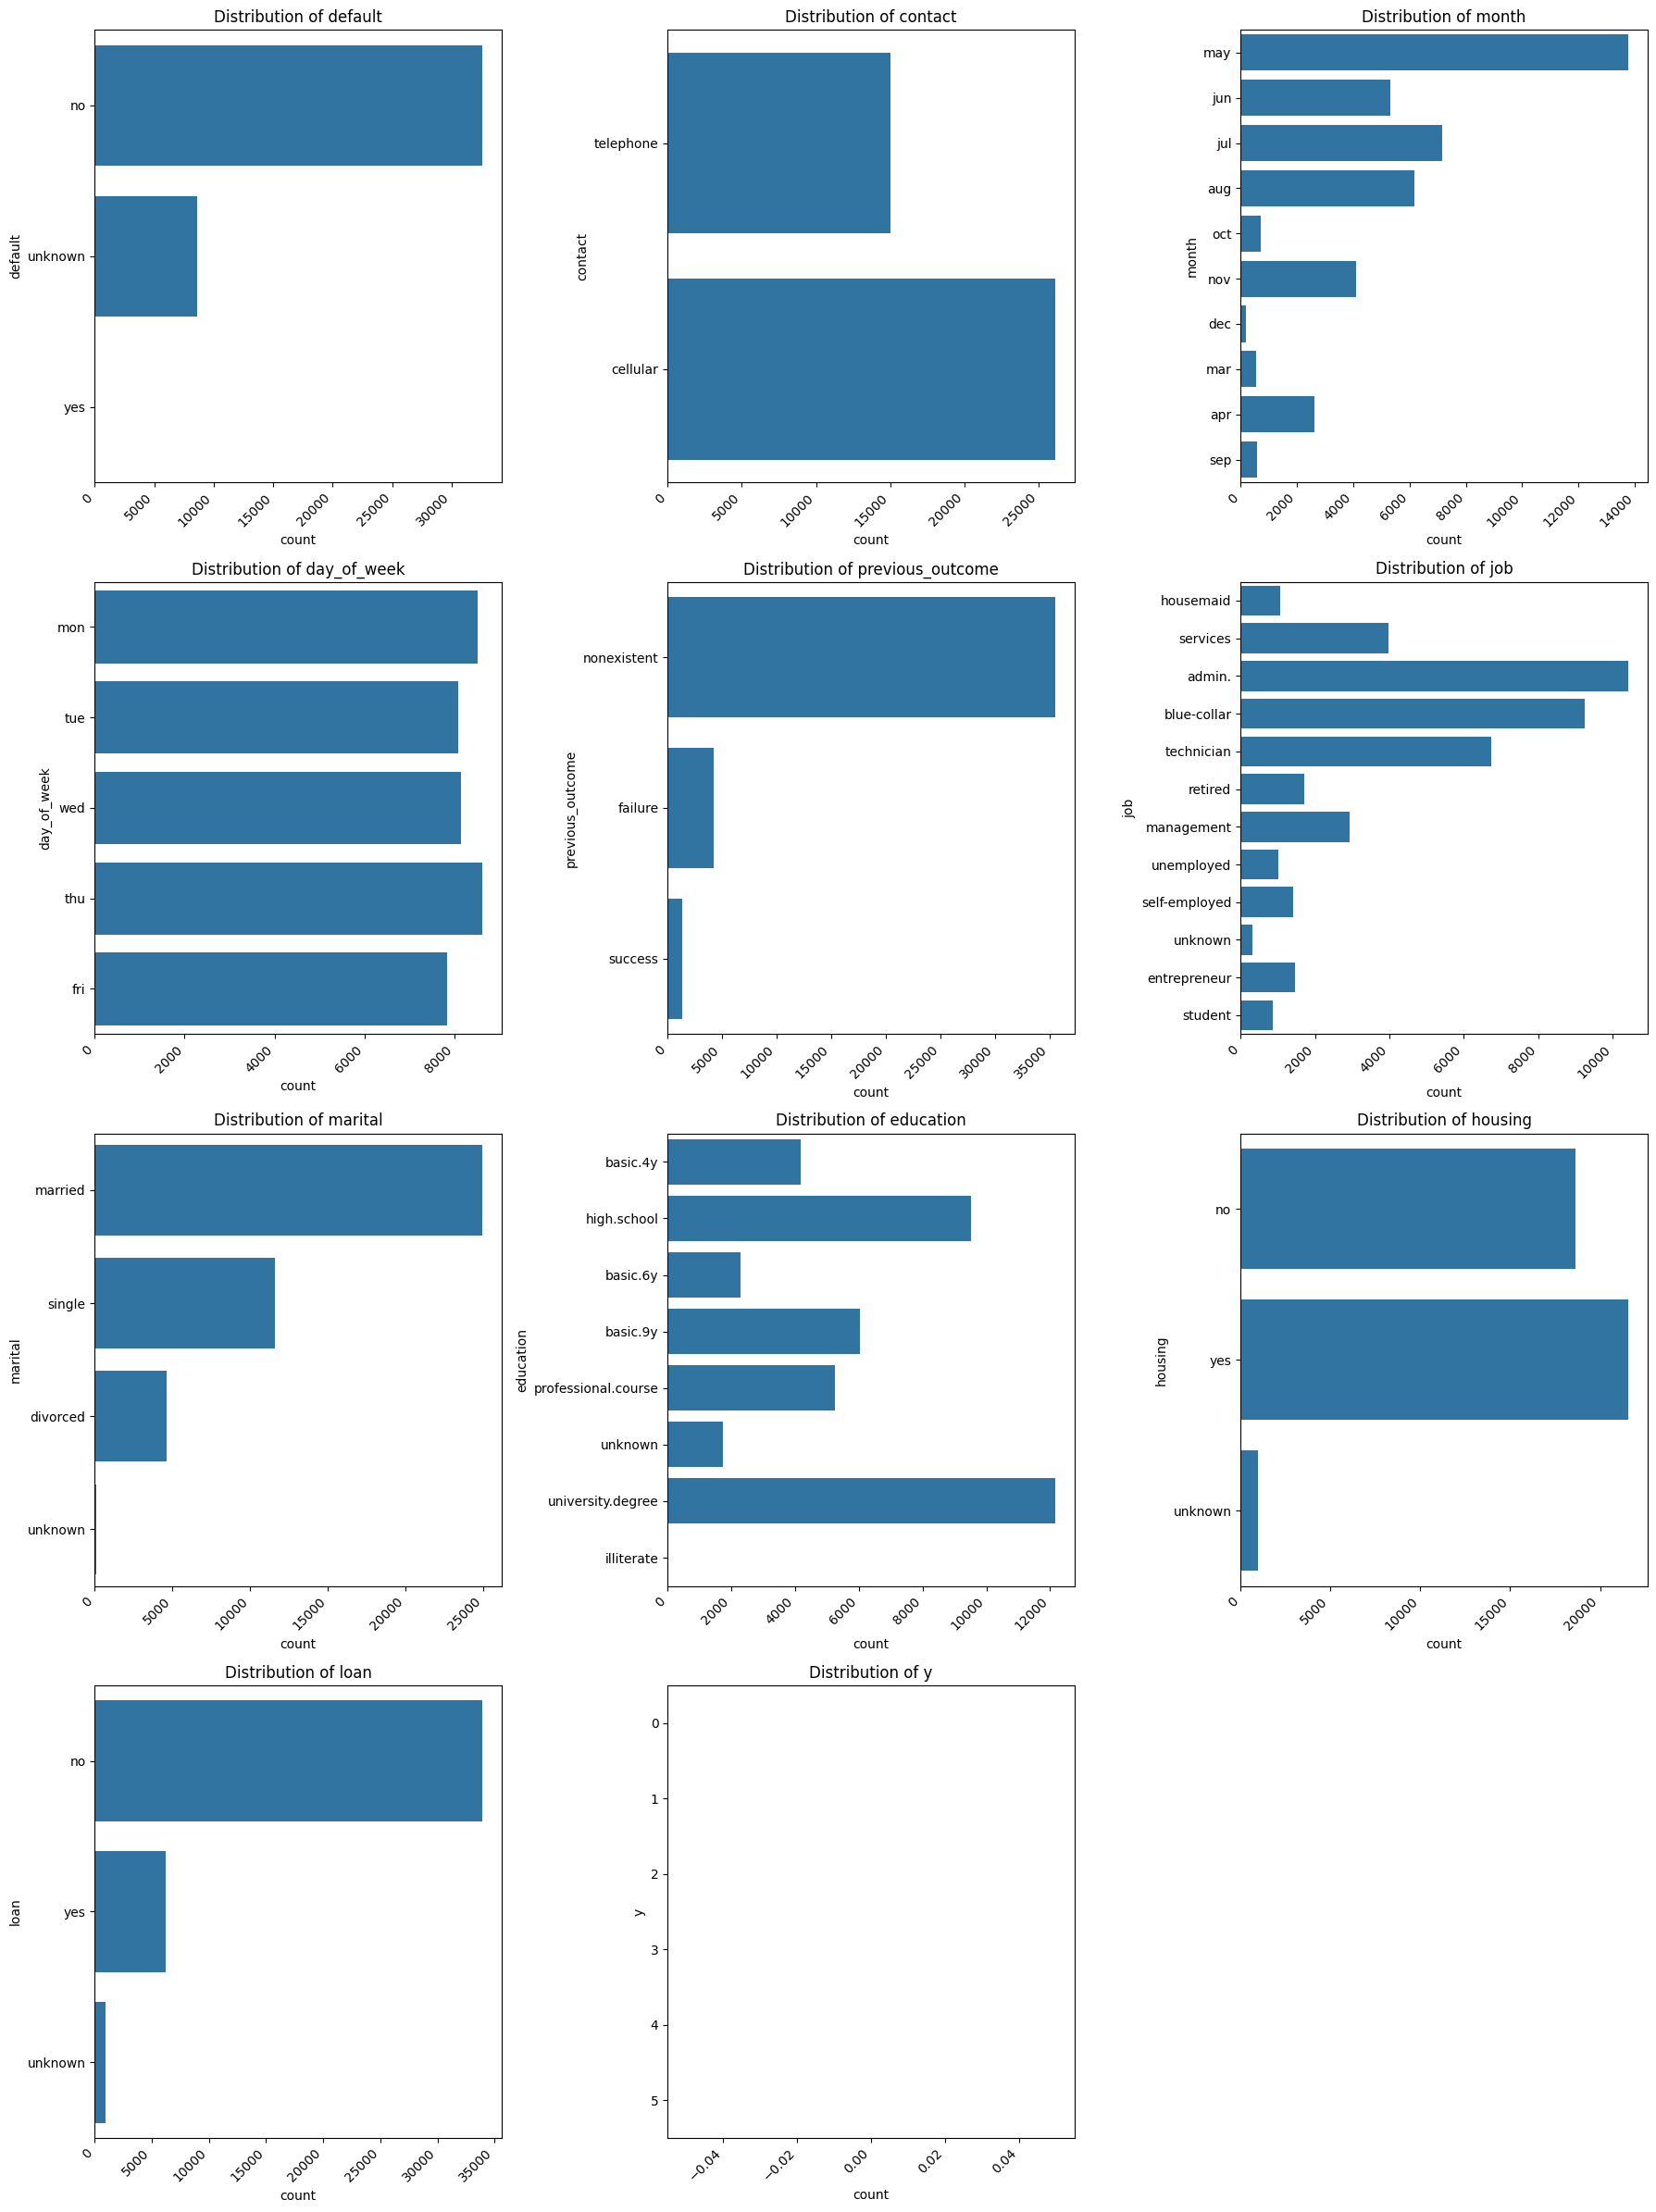

In [92]:


num_cols = 3
num_rows = int(np.ceil(len(categorical_columns) / num_cols))

plt.figure(figsize=(18, 6 * num_rows))

for i, col in enumerate(categorical_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.title(f'Distribution of {col}')
    sns.countplot(y=col, data=bank_df)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.show()

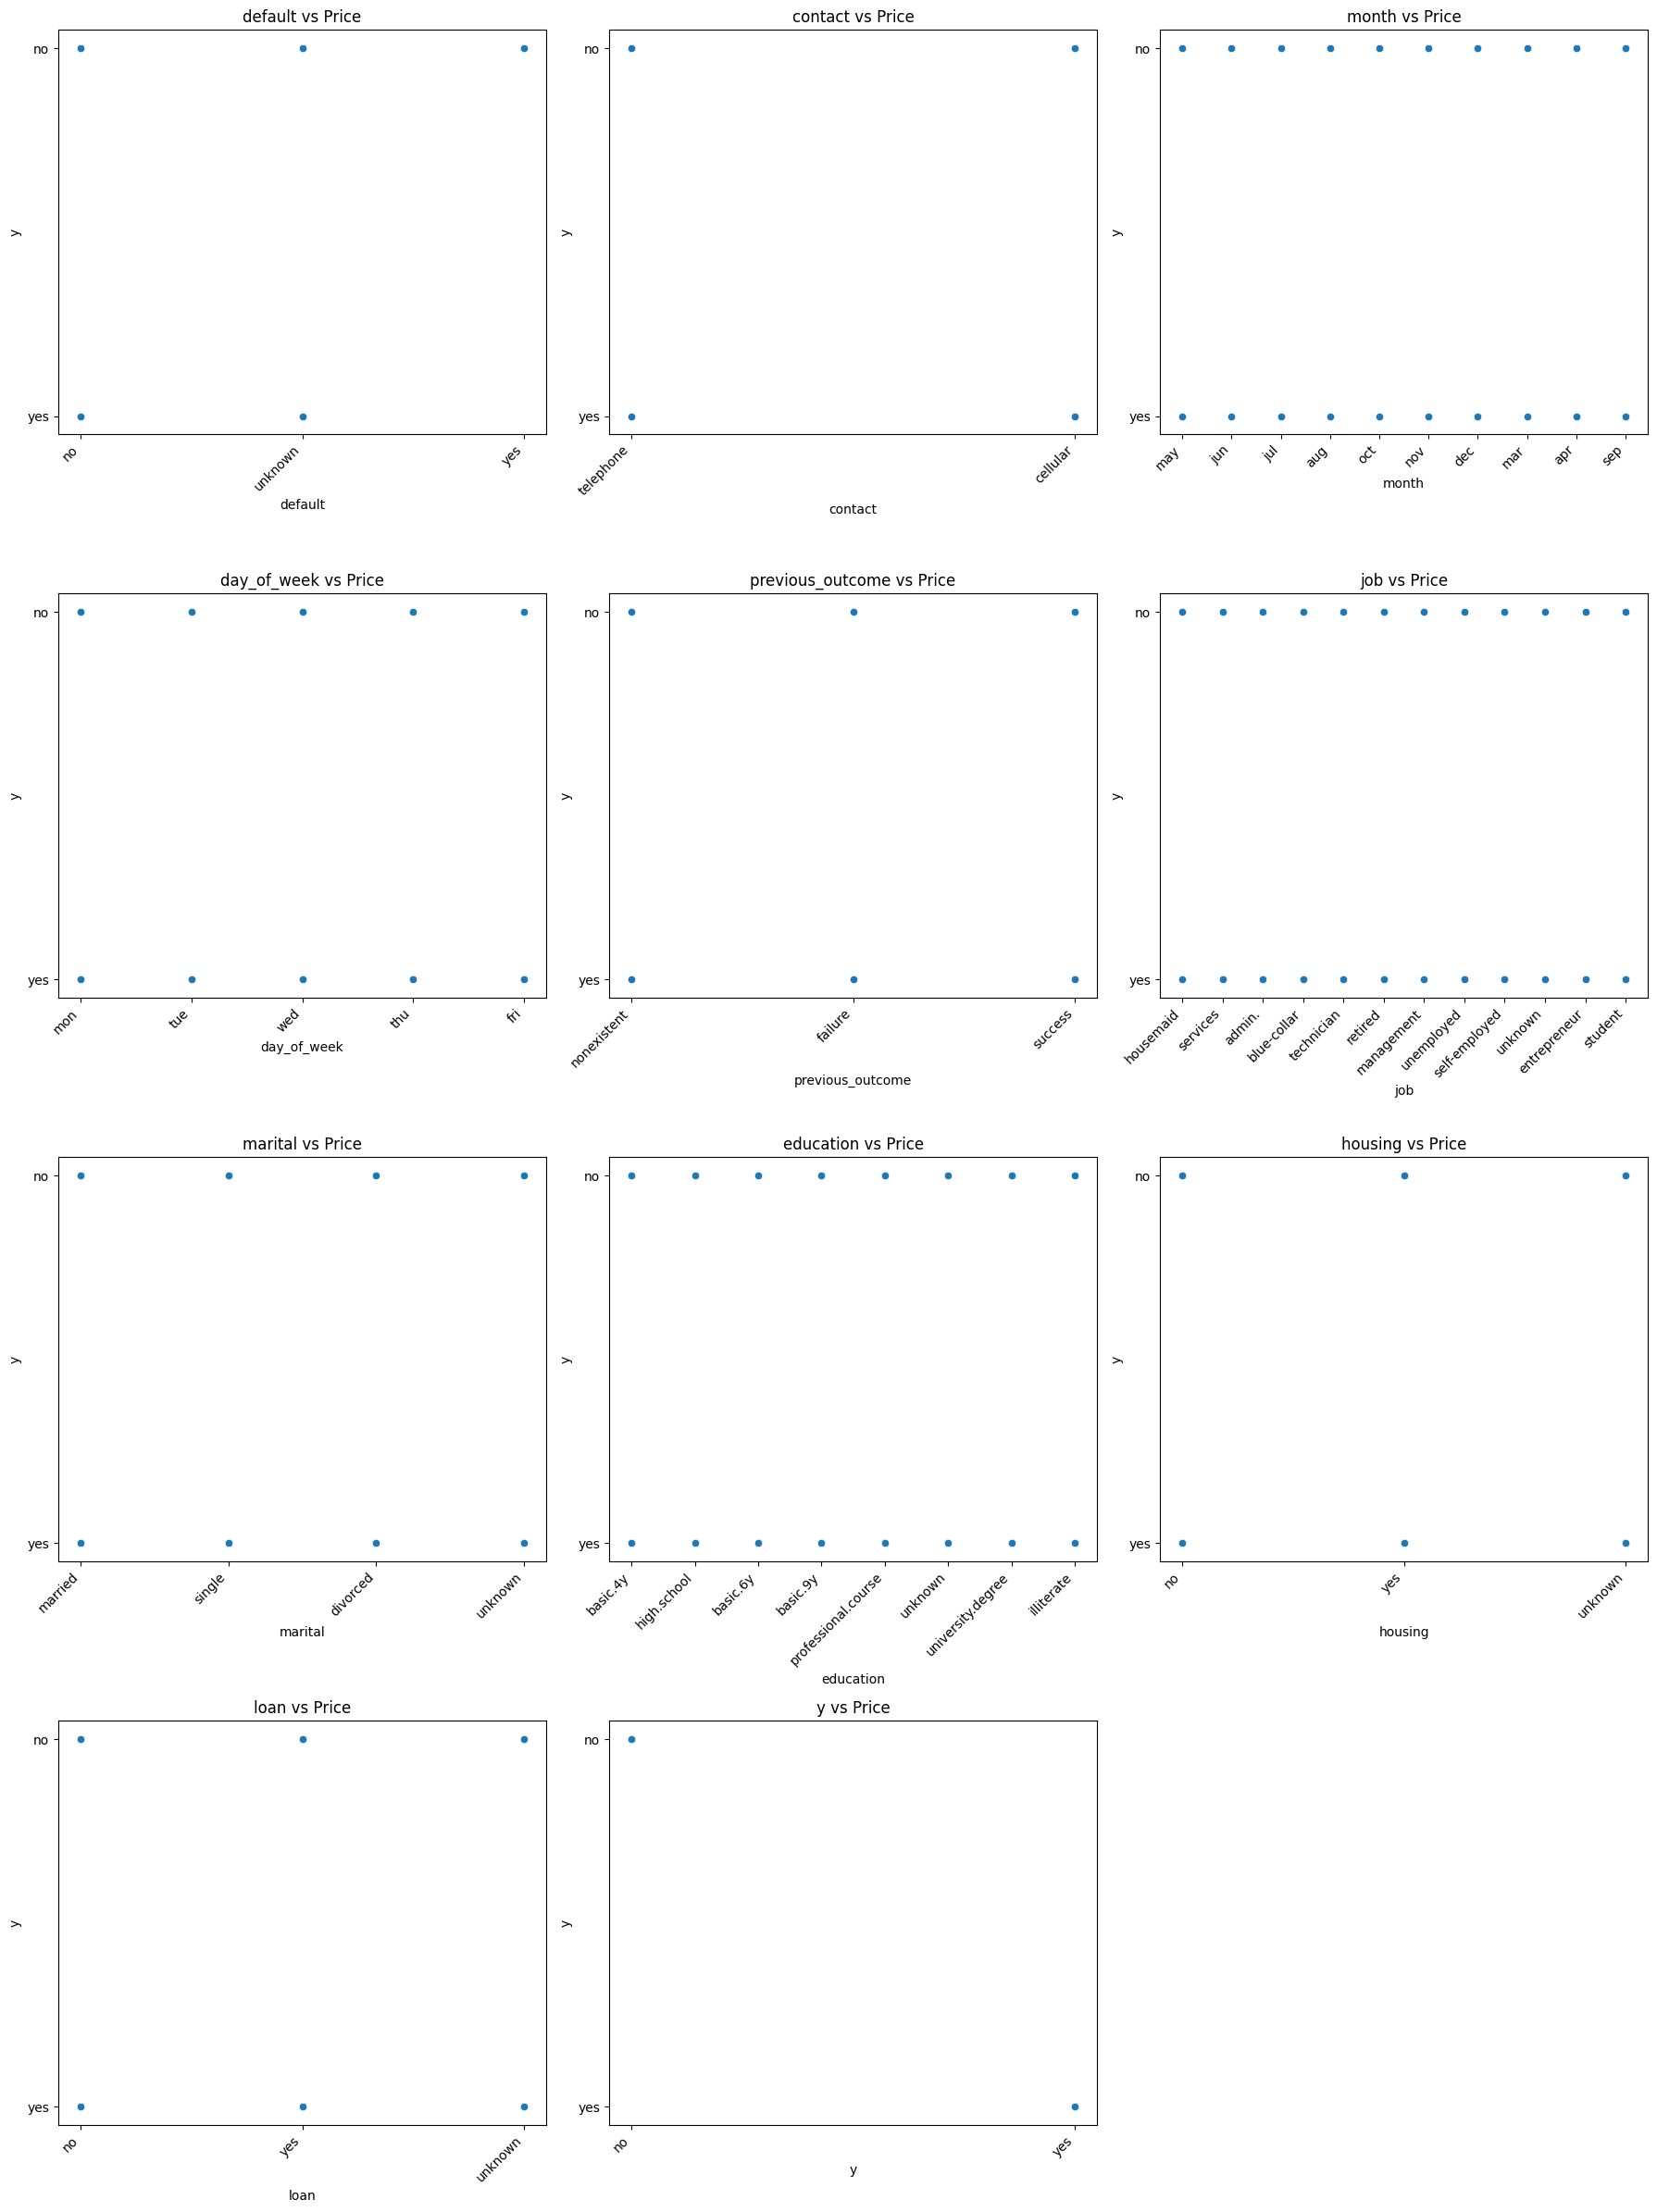

In [107]:
num_cols = 3
num_rows = int(np.ceil(len(categorical_columns) / num_cols))

plt.figure(figsize=(18, 6 * num_rows))

for i, col in enumerate(categorical_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.title(f'{col} vs Price')
    sns.scatterplot(x=bank_df[col], y=bank_df['y'])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.show()

In [94]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,days_since_last_contact,previous,previous_outcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_month_rate,number_of_employees,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,NaN
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,NaN
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,NaN
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,NaN
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,NaN


In [108]:
numerical_features = ['duration', 'age','days_since_last_contact','previous','employment_variation_rate','consumer_price_index','consumer_confidence_index','euribor_3_month_rate','number_of_employees']

bank_df[numerical_features].corr()


,duration,age,days_since_last_contact,previous,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_month_rate,number_of_employees
duration,1.000000,-0.000808,-0.047556,0.020600,-0.027941,0.005303,-0.008126,-0.032861,-0.044672
age,-0.000808,1.000000,-0.034381,0.024379,-0.000242,0.001009,0.129075,0.010852,-0.017607
days_since_last_contact,-0.047556,-0.034381,1.000000,-0.587508,0.271063,0.078920,-0.091374,0.296946,0.372659
previous,0.020600,0.024379,-0.587508,1.000000,-0.420587,-0.203197,-0.050929,-0.454571,-0.501411
employment_variation_rate,-0.027941,-0.000242,0.271063,-0.420587,1.000000,0.775293,0.196257,0.972244,0.906949
consumer_price_index,0.005303,0.001009,0.078920,-0.203197,0.775293,1.000000,0.059170,0.688180,0.521945
consumer_confidence_index,-0.008126,0.129075,-0.091374,-0.050929,0.196257,0.059170,1.000000,0.277864,0.100679
euribor_3_month_rate,-0.032861,0.010852,0.296946,-0.454571,0.972244,0.688180,0.277864,1.000000,0.945146
number_of_employees,-0.044672,-0.017607,0.372659,-0.501411,0.906949,0.521945,0.100679,0.945146,1.000000


In [109]:
y_mapping = {'yes': 1, 'no': 0}
bank_df['y'] = bank_df['y'].map(y_mapping)

correlations = bank_df[numerical_features + ['y']].corr()['y'].drop('y')

correlations
# duration, age and previous have high correlation with y


,y
duration,0.405297
age,0.030381
days_since_last_contact,-0.324948
previous,0.230202
employment_variation_rate,-0.298289
consumer_price_index,-0.136134
consumer_confidence_index,0.054802
euribor_3_month_rate,-0.307740
number_of_employees,-0.354669


In [98]:
pd.crosstab(bank_df['duration'],bank_df['age'])


age,17,18,19,20,21,22,23,24,25,26,...,85,86,87,88,89,91,92,94,95,98
duration,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:

bank_df.convert_dtypes()
bank_df_smallsize.convert_dtypes()
for col in categorical_columns:
    bank_df[col] = bank_df[col].astype('string')
    bank_df_smallsize[col] = bank_df_smallsize[col].astype('string')

In [100]:
bank_df.dtypes

,0
age,int64
job,string[python]
marital,string[python]
education,string[python]
default,string[python]
housing,string[python]
loan,string[python]
contact,string[python]
month,string[python]
day_of_week,string[python]


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [111]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        41176 non-null  int64  
 1   job                        41176 non-null  string 
 2   marital                    41176 non-null  string 
 3   education                  41176 non-null  string 
 4   default                    41176 non-null  string 
 5   housing                    41176 non-null  string 
 6   loan                       41176 non-null  string 
 7   contact                    41176 non-null  string 
 8   month                      41176 non-null  string 
 9   day_of_week                41176 non-null  string 
 10  duration                   41176 non-null  int64  
 11  campaign                   41176 non-null  int64  
 12  days_since_last_contact    41176 non-null  int64  
 13  previous                   41176 non-null  int64  


Identify the key customer demographics, behaviors, and economic factors that influence client's decision to subscribe to a term deposit. Use this information to optimize marketing campaigns, target specific customer segments, and increase term deposit subscription rates.



### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [112]:
categorical_columns = ['default','contact', 'month', 'day_of_week','previous_outcome','job','marital','education','housing','loan']
numerical_features = ['duration', 'age','days_since_last_contact','previous','employment_variation_rate','consumer_price_index','consumer_confidence_index','euribor_3_month_rate','number_of_employees']


# Create transformers
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_jamesSteinencoding_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent category
    ('label', ce.JamesSteinEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('catlabel',categorical_jamesSteinencoding_transformer,categorical_columns),
        ('poly', PolynomialFeatures(degree=1,include_bias = False), numerical_features)
    ])

In [113]:
X = bank_df.drop('y', axis=1)
y = bank_df['y']
X_small = bank_df_smallsize.drop('y', axis=1)
y_small = bank_df_smallsize['y']

In [114]:
preprocessed_bank_df=preprocessor.fit_transform(X,y)
preprocessed_bank_df_small=preprocessor.fit_transform(X_small,y_small)



### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [115]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_bank_df, y,
                                                    test_size = 0.2,
                                                    random_state = 42)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(preprocessed_bank_df_small, y_small,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [116]:
preprocessor.get_feature_names_out()

array(['num__duration', 'num__age', 'num__days_since_last_contact',
       'num__previous', 'num__employment_variation_rate',
       'num__consumer_price_index', 'num__consumer_confidence_index',
       'num__euribor_3_month_rate', 'num__number_of_employees',
       'catlabel__0', 'catlabel__1', 'catlabel__2', 'catlabel__3',
       'catlabel__4', 'catlabel__5', 'catlabel__6', 'catlabel__7',
       'catlabel__8', 'catlabel__9', 'poly__duration', 'poly__age',
       'poly__days_since_last_contact', 'poly__previous',
       'poly__employment_variation_rate', 'poly__consumer_price_index',
       'poly__consumer_confidence_index', 'poly__euribor_3_month_rate',
       'poly__number_of_employees'], dtype=object)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?


Dummy Classifier:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      7265
           1       0.00      0.00      0.00       971

    accuracy                           0.88      8236
   macro avg       0.44      0.50      0.47      8236
weighted avg       0.78      0.88      0.83      8236

Accuracy: 0.8821029626032054


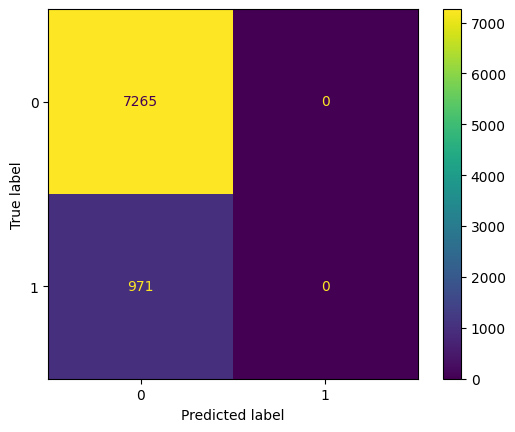

In [117]:

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_predictions = dummy_clf.predict(X_test)
print("\nDummy Classifier:")
print(classification_report(y_test, dummy_predictions))
print(f"Accuracy: {accuracy_score(y_test,dummy_predictions)}")
cm = confusion_matrix(y_test, dummy_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_clf.classes_)
disp.plot()
plt.show()

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7265
           1       0.66      0.39      0.49       971

    accuracy                           0.90      8236
   macro avg       0.79      0.68      0.72      8236
weighted avg       0.89      0.90      0.89      8236



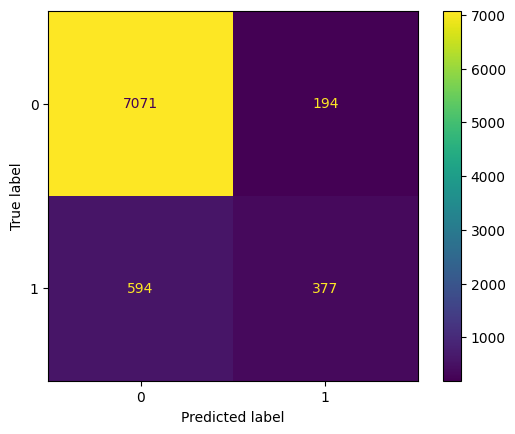

In [118]:
model=LogisticRegression()
start_time = time.time()
model.fit(X_train, y_train)

lr_y_pred = model.predict(X_test)

print(classification_report(y_test, lr_y_pred))
cm = confusion_matrix(y_test, lr_y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()



### Problem 9: Score the Model

What is the accuracy of your model?

In [119]:
print( accuracy_score(y_test, lr_y_pred))
# Accuracy of logistic Regression is 90%

0.9043224866440019










### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [120]:
# Run KNN, Decision Tree, Logistic Regression and SVM with default parameters and observe the accuracy score on test data
model_results = {
    "Model": [],
    "Train Time": [],
    "Train Accuracy": [],
    "Test_accuracy": [],
}

models = {
    'kNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC()
}
for model_name,model in models.items():
  start_time = time.time()
  model.fit(X_train, y_train)
  train_time = time.time() - start_time
  y_pred_train = model.predict(X_train)
  train_accuracy = accuracy_score(y_train, y_pred_train)

  y_pred = model.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_pred)

  model_results["Model"].append(model_name)
  model_results["Train Time"].append(train_time)
  model_results["Train Accuracy"].append(train_accuracy)
  model_results["Test_accuracy"].append(test_accuracy)
model_results=pd.DataFrame(model_results)
model_results
# On test data,Logistic Regression and KNN were more accurate than decision tree and SVM

,Model,Train Time,Train Accuracy,Test_accuracy
0,kNN,0.097042,0.931117,0.902380
1,Decision Tree,0.416925,1.000000,0.888538
2,Logistic Regression,0.709427,0.910656,0.904322
3,SVM,19.547464,0.898907,0.893881


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

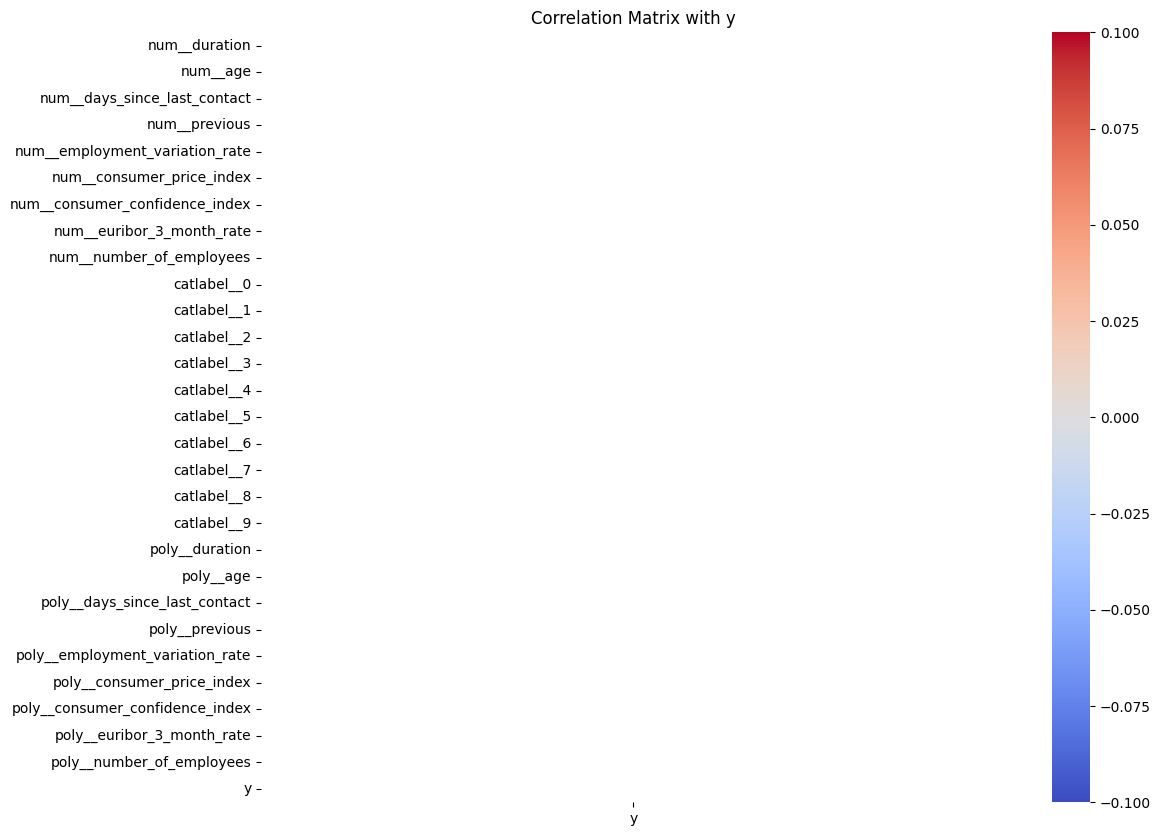

In [121]:

feature_names = preprocessor.get_feature_names_out()

bank_df_preprocessed = pd.DataFrame(preprocessed_bank_df, columns=feature_names)
bank_df_small_preprocessed=pd.DataFrame(preprocessed_bank_df_small, columns=feature_names)


bank_df_preprocessed['y'] = y.map({'no': 0, 'yes': 1})
bank_df_small_preprocessed['y']=y_small.map({'no': 0, 'yes': 1})

correlation_matrix = bank_df_preprocessed.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[['y']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with y')
plt.show()


In [122]:

# Identify columns with low correlation to 'y' and remove them
threshold = 0.10
low_correlation_cols = correlation_matrix[abs(correlation_matrix['y']) < threshold].index.tolist()


print("Columns with low correlation to 'y':", low_correlation_cols)
bank_df_preprocessed = bank_df_preprocessed.drop(columns=low_correlation_cols)
bank_df_small_preprocessed=bank_df_small_preprocessed.drop(columns=low_correlation_cols)


Columns with low correlation to 'y': []


In [22]:
bank_df_preprocessed

,num__days_since_last_contact,num__previous,num__employment_variation_rate,num__consumer_price_index,num__euribor_3_month_rate,num__number_of_employees,catlabel__1,catlabel__2,catlabel__4,catlabel__5,poly__days_since_last_contact,poly__previous,poly__employment_variation_rate,poly__consumer_price_index,poly__euribor_3_month_rate,poly__number_of_employees,y
0,0.195443,-0.349551,0.648101,0.722628,0.712463,0.331695,0.052324,0.078481,0.088324,0.104911,999.0,0.0,1.1,93.994,4.857,5191.0,0.0
1,0.195443,-0.349551,0.648101,0.722628,0.712463,0.331695,0.052324,0.078481,0.088324,0.092362,999.0,0.0,1.1,93.994,4.857,5191.0,0.0
2,0.195443,-0.349551,0.648101,0.722628,0.712463,0.331695,0.052324,0.078481,0.088324,0.092362,999.0,0.0,1.1,93.994,4.857,5191.0,0.0
3,0.195443,-0.349551,0.648101,0.722628,0.712463,0.331695,0.052324,0.078481,0.088324,0.122289,999.0,0.0,1.1,93.994,4.857,5191.0,0.0
4,0.195443,-0.349551,0.648101,0.722628,0.712463,0.331695,0.052324,0.078481,0.088324,0.092362,999.0,0.0,1.1,93.994,4.857,5191.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,0.195443,-0.349551,-0.752402,2.058076,-1.495197,-2.815689,0.147389,0.105619,0.088324,0.177737,999.0,0.0,-1.1,94.767,1.028,4963.6,1.0
41172,0.195443,-0.349551,-0.752402,2.058076,-1.495197,-2.815689,0.147389,0.105619,0.088324,0.082937,999.0,0.0,-1.1,94.767,1.028,4963.6,1.0
41173,0.195443,-0.349551,-0.752402,2.058076,-1.495197,-2.815689,0.147389,0.105619,0.088324,0.177737,999.0,0.0,-1.1,94.767,1.028,4963.6,1.0
41174,0.195443,-0.349551,-0.752402,2.058076,-1.495197,-2.815689,0.147389,0.105619,0.088324,0.110069,999.0,0.0,-1.1,94.767,1.028,4963.6,1.0


In [123]:
feature_names = [feature for feature in feature_names if feature not in low_correlation_cols]


In [124]:

param_grid = {
    'n_neighbors': range(1, 31,2),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting function for neighbors
    'metric': ['minkowski','euclidean'] # Distance metric to use
}
roc_grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring = 'roc_auc')
roc_grid.fit(X_small_train, y_small_train)

best_knn = roc_grid.best_params_
print("best KNN Parameters are",best_knn)

knn_y_pred = roc_grid.predict(X_small_test)
knn_accuracy = accuracy_score(y_small_test, knn_y_pred)
print("Accuracy with best hyperparameters:", knn_accuracy)

best KNN Parameters are {'metric': 'minkowski', 'n_neighbors': 25, 'weights': 'uniform'}
Accuracy with best hyperparameters: 0.8968446601941747


In [125]:
# Decision Tree Hyperparameter Tuning
param_grid_dt = {
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'splitter': ['best', 'random'],  # Splitting strategy
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'], # Number of features to consider for the best split
    'max_leaf_nodes' : [None, 10, 20, 30, 40, 50] # Maximum number of leaf nodes in the tree
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, scoring='roc_auc', cv=5)
grid_search_dt.fit(X_small_train, y_small_train)

print("Best hyperparameters for Decision Tree:", grid_search_dt.best_params_)
best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_small_test)
accuracy_dt = accuracy_score(y_small_test, y_pred_dt)
print("Accuracy of best Decision Tree Model:",accuracy_dt)


Best hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Accuracy of best Decision Tree Model: 0.9016990291262136


In [126]:
for feature, importance in zip(feature_names, best_dt_model.feature_importances_):
    print(f"{feature}: {importance}")
    # this indicates that ,poly__duration,num__euribor_3_month_rate ,consumer_confidence_index have high importance


num__duration: 0.007753433228561525
num__age: 0.0
num__days_since_last_contact: 0.0
num__previous: 0.0
num__employment_variation_rate: 0.016029240069939606
num__consumer_price_index: 0.0
num__consumer_confidence_index: 0.13494188819934405
num__euribor_3_month_rate: 0.3042238331524046
num__number_of_employees: 0.0
catlabel__0: 0.0
catlabel__1: 0.012451121040942219
catlabel__2: 0.02333965286773141
catlabel__3: 0.0
catlabel__4: 0.04919526741886521
catlabel__5: 0.009576813874225473
catlabel__6: 0.0
catlabel__7: 0.0
catlabel__8: 0.0
catlabel__9: 0.0
poly__duration: 0.40648349070281214
poly__age: 0.0
poly__days_since_last_contact: 0.0
poly__previous: 0.0
poly__employment_variation_rate: 0.0
poly__consumer_price_index: 0.010059958486219253
poly__consumer_confidence_index: 0.025945300958954608
poly__euribor_3_month_rate: 0.0
poly__number_of_employees: 0.0


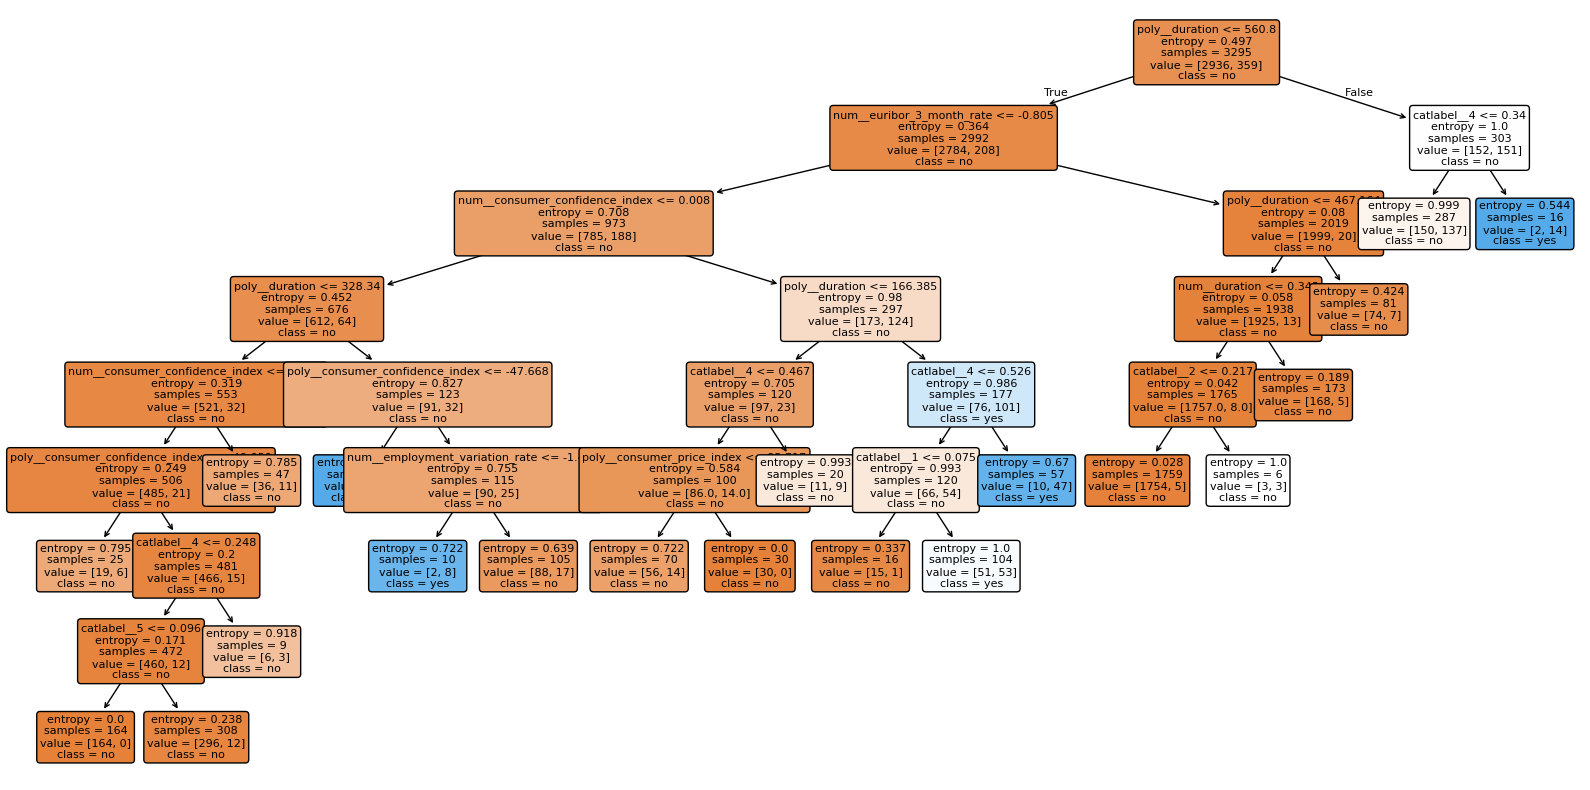

In [133]:
from sklearn import tree

plt.figure(figsize=(20, 10))  # Adjust figure size as needed
tree.plot_tree(best_dt_model,
               feature_names=feature_names,
               class_names=["no", "yes"],
               filled=True,
               rounded=True,
               fontsize=8)
plt.show()


In [134]:


print(classification_report(y_small_test, knn_y_pred))
print(classification_report(y_small_test, y_pred_dt))


              precision    recall  f1-score   support

          no       0.93      0.95      0.94       732
         yes       0.55      0.45      0.49        92

    accuracy                           0.90       824
   macro avg       0.74      0.70      0.72       824
weighted avg       0.89      0.90      0.89       824

              precision    recall  f1-score   support

          no       0.92      0.97      0.95       732
         yes       0.61      0.34      0.43        92

    accuracy                           0.90       824
   macro avg       0.76      0.65      0.69       824
weighted avg       0.89      0.90      0.89       824



In [135]:

param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'degree': [2, 3, 4],
}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, scoring='roc_auc', cv=5)
grid_search_svm.fit(X_small_train, y_small_train)

print("Best hyperparameters for SVM:", grid_search_svm.best_params_)
best_svm_model = grid_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_small_test)
accuracy_svm = accuracy_score(y_small_test, y_pred_svm)
print("Accuracy of best SVM Model:", accuracy_svm)

print(classification_report(y_small_test, y_pred_svm))


Best hyperparameters for SVM: {'C': 0.1, 'degree': 2, 'kernel': 'linear'}
Accuracy of best SVM Model: 0.9053398058252428
              precision    recall  f1-score   support

          no       0.93      0.97      0.95       732
         yes       0.62      0.39      0.48        92

    accuracy                           0.91       824
   macro avg       0.77      0.68      0.71       824
weighted avg       0.89      0.91      0.90       824



In [137]:
for feature, importance in zip(feature_names, best_svm_model.support_vectors_):
    print(f"{feature}: {importance}")

num__duration: [ 1.51650243e+00  1.15266233e+00  2.01031335e-01 -3.51355984e-01
  6.49441345e-01  7.15192643e-01  8.92269070e-01  7.12852220e-01
  3.32862495e-01  1.21266968e-01  5.18064076e-02  7.85465726e-02
  1.05649024e-01  8.28839058e-02  1.21742480e-01  1.01890105e-01
  1.06785576e-01  1.09842306e-01  1.11675127e-01  6.43000000e+02
  5.20000000e+01  9.99000000e+02  0.00000000e+00  1.10000000e+00
  9.39940000e+01 -3.64000000e+01  4.85700000e+00  5.19100000e+03]
num__age: [-3.68268812e-01 -8.83778413e-01  2.01031335e-01 -3.51355984e-01
 -1.20605432e+00 -1.18544763e+00 -1.24093900e+00 -1.35882185e+00
 -9.14779330e-01  1.21266968e-01  1.41402715e-01  7.85465726e-02
  1.11089319e-01  8.28839058e-02  9.66610834e-02  1.29907599e-01
  1.22449992e-01  1.10344828e-01  1.11675127e-01  1.63000000e+02
  3.10000000e+01  9.99000000e+02  0.00000000e+00 -1.80000000e+00
  9.28930000e+01 -4.62000000e+01  1.26600000e+00  5.09910000e+03]
num__days_since_last_contact: [ 4.09199326e-01 -1.07772515e+00 

In [ ]:
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score" : []
}
model=LogisticRegression()
model.fit(X_small_train, y_small_train)

lr_y_pred = model.predict(X_small_test)

results['Model'].append('Logistic Regression')
results['Accuracy'].append(accuracy_score(y_small_test,lr_y_pred))
results['Precision'].append(precision_score(y_small_test,lr_y_pred,pos_label='yes'))
results['Recall'].append(recall_score(y_small_test,lr_y_pred,pos_label='yes'))
results['F1-score'].append(f1_score(y_small_test,lr_y_pred,pos_label='yes'))
results['Model'].append('KNN')
results['Accuracy'].append(knn_accuracy)
results['Precision'].append(precision_score(y_small_test,knn_y_pred,pos_label='yes'))
results['Recall'].append(recall_score(y_small_test,knn_y_pred,pos_label='yes'))
results['F1-score'].append(f1_score(y_small_test,knn_y_pred,pos_label='yes'))
results['Model'].append('Decision Tree')
results['Accuracy'].append(accuracy_dt)
results['Precision'].append(precision_score(y_small_test,y_pred_dt,pos_label='yes'))
results['Recall'].append(recall_score(y_small_test,y_pred_dt,pos_label='yes'))
results['F1-score'].append(f1_score(y_small_test,y_pred_dt,pos_label='yes'))
results['Model'].append('SVM')
results['Accuracy'].append(accuracy_svm)
results['Precision'].append(precision_score(y_small_test,y_pred_svm,pos_label='yes'))
results['Recall'].append(recall_score(y_small_test,y_pred_svm,pos_label='yes'))
results['F1-score'].append(f1_score(y_small_test,y_pred_svm,pos_label='yes'))



In [ ]:
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.906553,0.641509,0.369565,0.468966
1,KNN,0.896845,0.546667,0.445652,0.491018
2,Decision Tree,0.896845,0.550725,0.413043,0.472050
3,SVM,0.905340,0.620690,0.391304,0.480000


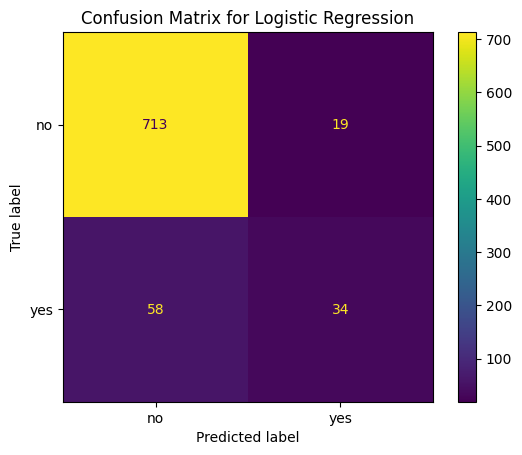

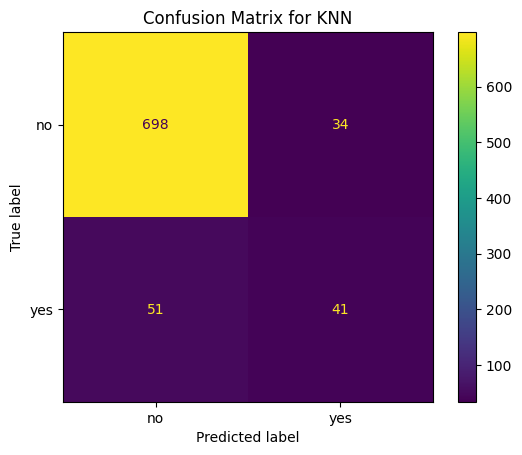

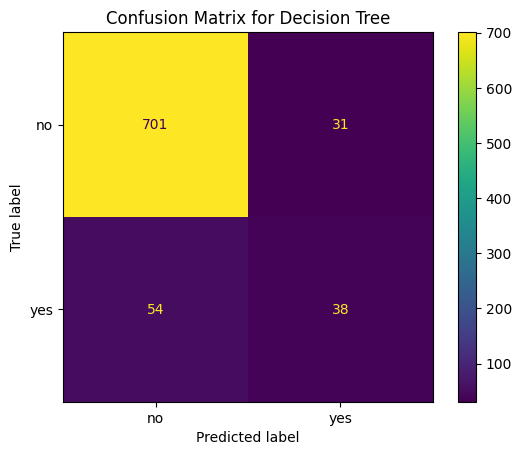

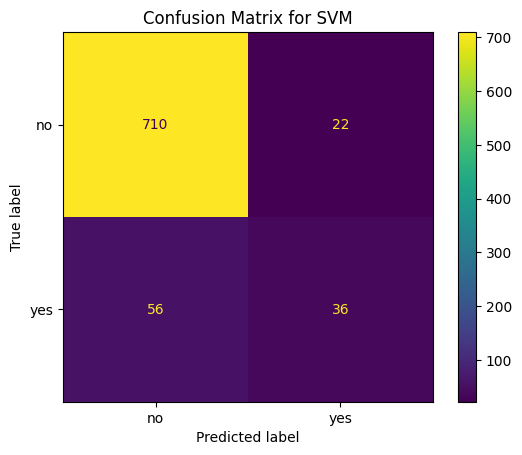

In [ ]:

models_predictions = {
    "Logistic Regression": lr_y_pred,
    "KNN": knn_y_pred,
    "Decision Tree": y_pred_dt,
    "SVM": y_pred_svm,
}

for model_name, predictions in models_predictions.items():
    cm = confusion_matrix(y_small_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_small_test))
    disp.plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


In [ ]:
# Value Counts of 'yes' and 'no' in y_small_test
y_small_test.value_counts()


,count
y,
no,732
yes,92



Since the count of 'no' are way higher than 'yes', the model is biased towards predicting 'no'. So in such cases, instead of accuracy score, comparing the models
should be done based on other metrics like precision, recall and f1-score.

So, considering the precision_score,  recall_score and f1_score for SVM, LogisticRegression, DecisionTree and KNN, KNN is the best model for this dataset if run with
 Parameters  {'metric': 'minkowski', 'n_neighbors': 25, 'weights': 'uniform'}